# 二手房交易分析

## 目标

通过数据分析，对后续二手房交易策略提供支持，计划进行如下维度分析

1. 小区户型交易热点，掌握哪些户型易于成交
2. 用户行为，户型与交易周期的关系，了解一个新挂的二手房，什么情况下可能成交，以及相应的议价空间
3. 交易趋势，确认政策对交易的量化影响，以及目前的价格走势

随后形成如下认知：

1. 户型后续出手难度
2. 户型定价策略，报价博弈策略
3. 潜在竞争客户应对策略

最终用户如下决策

1. 买什么户型
2. 报多少价格
3. 如何进行议价

# 结论模板

1. 交易热点：小区成交热点户型，面积，朝向，楼层
2. 交易趋势：成交均价随月份趋势和分布，挂牌价与成交价gap的均值和线框图
3. 交易行为：成交前平均带看次数和成交周期分布和趋势

In [57]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline

In [58]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
pd.set_option("display.max_rows", None)
#pd.reset_option("display.max_rows")

# 一. 数据载入&预处理

In [3]:
# 载入数据
data = pd.read_csv('../畅柳园.csv')

In [4]:
# 预览数据
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,listing_time,last_transaction_duration,transaction_price,history_trade_count,listed_price,transaction_duration,price_change_count,visit_count,follower_count,page_view_count
0,畅柳园 1室1厅 55.7平米,2019.11.30,畅柳园,1室1厅1厨1卫,高楼层(共14层),55.7㎡,板塔结合,西,2004,101106384464,2019-11-28,满五年,596,1,598,2,0,4,0,暂无数据
1,畅柳园 1室1厅 52.3平米,2019.07.14,畅柳园,1室1厅1厨1卫,高楼层(共16层),52.3㎡,板塔结合,南,2003,101104850984,2019-06-01,满五年,605,1,630,44,0,4,17,612
2,畅柳园 2室1厅 66.05平米,2019.07.27,畅柳园,2室1厅1厨1卫,中楼层(共14层),66.05㎡,板塔结合,南,2004,101105124945,2019-07-04,满五年,730,1,750,24,1,43,30,609


In [5]:
# 预览大小和特征数
data.shape

(451, 20)

In [6]:
#处理日期数据
data['deal_date'] = pd.to_datetime(data['deal_date'])
data['listing_time'] = pd.to_datetime(data['listing_time'], errors='coerce')
data['deal_month'] = data['deal_date'].dt.to_period('M').dt.to_timestamp()
data['deal_year'] = data['deal_date'].dt.to_period('Y').dt.to_timestamp()

In [7]:
# 转成整数类型日期
data['deal_month_num'] = data['deal_month'].dt.strftime('%Y%m')
data['deal_month_num'] = data['deal_month_num'].map(lambda x:int(x) if isinstance(x, str) else x)

In [8]:
data.dtypes

title                                object
deal_date                    datetime64[ns]
community                            object
house_type                           object
floor                                object
area                                 object
building_type                        object
orientation                          object
build_year                            int64
lianjia_id                           object
listing_time                 datetime64[ns]
last_transaction_duration            object
transaction_price                    object
history_trade_count                   int64
listed_price                         object
transaction_duration                 object
price_change_count                    int64
visit_count                           int64
follower_count                        int64
page_view_count                      object
deal_month                   datetime64[ns]
deal_year                    datetime64[ns]
deal_month_num                  

In [9]:
# 处理数值型数据转换
# 成交周期
data['transaction_duration'] = data['transaction_duration'].map(lambda x: np.nan if x=='暂无数据' or x is np.nan else int(x)).astype('Int64',errors='ignore')
# 面积
data['area'] = data['area'].map(lambda x: float(x.strip('㎡') if x != '暂无数据' else np.nan))
# 成交价
def convert_int(numberStr):
    if isinstance(numberStr, int) or isinstance(numberStr, float):
        return numberStr
    if numberStr == '暂无数据':
        return np.nan
    elif '.' in numberStr:
        return int(numberStr.split('.')[0])
    elif '-' not in numberStr:
        return int(numberStr)
    else:
        low,up = numberStr.split('-')
        return int((int(low)+int(up))/2)
data['transaction_price'] = data['transaction_price'].map(convert_int)

# 挂牌价
data['listed_price'] = data['listed_price'].map(convert_int).astype('Int64')

# 浏览数
data['page_view_count'] = data['page_view_count'].map(convert_int).astype('Int64')

In [10]:
#处理字符串类型
# 朝向
data['orientation'] = data['orientation'].map(lambda x: ''.join(set([i for i in x if i != ' '])))

In [11]:
# 新列
# 每平米价格
data['per_area_price'] = data['transaction_price']/data['area']
# 成交价-报价
data['transaction_listed_price_gap'] = data['transaction_price']-data['listed_price']

def convert_area_level(area):
    return int(round(area/10))*10

def convert_room_count(house_type):
    try:
        return int(house_type[0])
    except Exception:
        return 0

# 面积阶梯
data['area_level'] = data['area'].map(convert_area_level)
# 房间数归一化
data['room_count'] = data['house_type'].map(convert_room_count)

In [12]:
data.dtypes

title                                   object
deal_date                       datetime64[ns]
community                               object
house_type                              object
floor                                   object
area                                   float64
building_type                           object
orientation                             object
build_year                               int64
lianjia_id                              object
listing_time                    datetime64[ns]
last_transaction_duration               object
transaction_price                        int64
history_trade_count                      int64
listed_price                             Int64
transaction_duration                     Int64
price_change_count                       int64
visit_count                              int64
follower_count                           int64
page_view_count                          Int64
deal_month                      datetime64[ns]
deal_year    

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 27 columns):
title                           451 non-null object
deal_date                       451 non-null datetime64[ns]
community                       451 non-null object
house_type                      451 non-null object
floor                           451 non-null object
area                            451 non-null float64
building_type                   451 non-null object
orientation                     451 non-null object
build_year                      451 non-null int64
lianjia_id                      451 non-null object
listing_time                    446 non-null datetime64[ns]
last_transaction_duration       451 non-null object
transaction_price               451 non-null int64
history_trade_count             451 non-null int64
listed_price                    418 non-null Int64
transaction_duration            337 non-null Int64
price_change_count              451 non-null int64


In [14]:
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,...,visit_count,follower_count,page_view_count,deal_month,deal_year,deal_month_num,per_area_price,transaction_listed_price_gap,area_level,room_count
0,畅柳园 1室1厅 55.7平米,2019-11-30,畅柳园,1室1厅1厨1卫,高楼层(共14层),55.70,板塔结合,西,2004,101106384464,...,4,0,NaN,2019-11-01,2019-01-01,201911,10.700180,-2,60,1
1,畅柳园 1室1厅 52.3平米,2019-07-14,畅柳园,1室1厅1厨1卫,高楼层(共16层),52.30,板塔结合,南,2003,101104850984,...,4,17,612,2019-07-01,2019-01-01,201907,11.567878,-25,50,1
2,畅柳园 2室1厅 66.05平米,2019-07-27,畅柳园,2室1厅1厨1卫,中楼层(共14层),66.05,板塔结合,南,2004,101105124945,...,43,30,609,2019-07-01,2019-01-01,201907,11.052233,-20,70,2


# 二. 数据分析

户型种类

In [15]:
print(data['house_type'].unique())

['1室1厅1厨1卫' '2室1厅1厨1卫' '3室1厅1厨1卫' '3室2厅1厨1卫' '1室2厅1厨1卫' '3室1厅1厨2卫'
 '2室2厅1厨2卫' '- -室- -厅' '3室2厅1厨2卫' '2室1厅1厨0卫' '2室1厅2厨1卫' '2室2厅1厨1卫'
 '2室3厅1厨2卫']


建成年代

In [16]:
print(data['build_year'].unique())

[2004 2003 2002]


## 2.1 交易行为

### 1）户型交易分布

可以查看交易主力户型和朝向

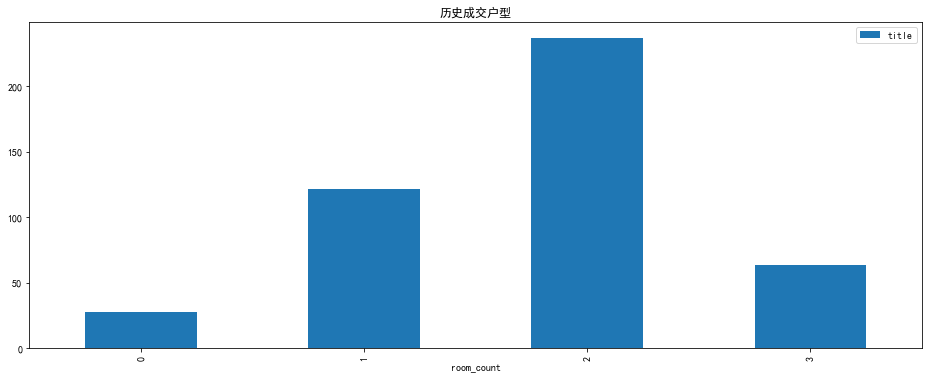

In [17]:
data.groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型')

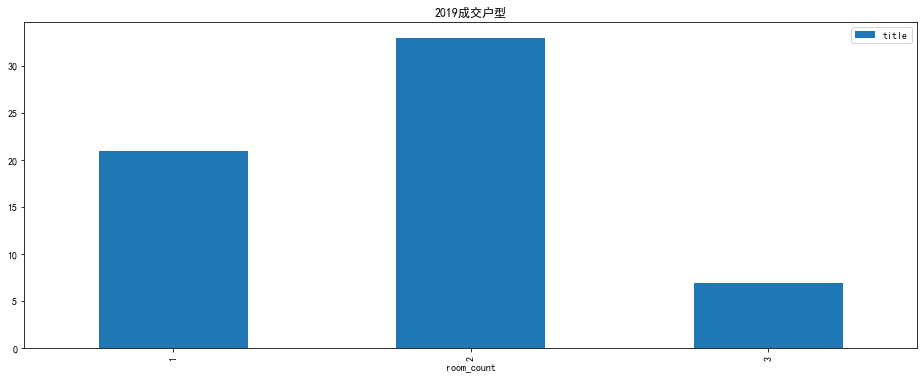

In [18]:
data[data['deal_date']>='2019'].groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交户型')

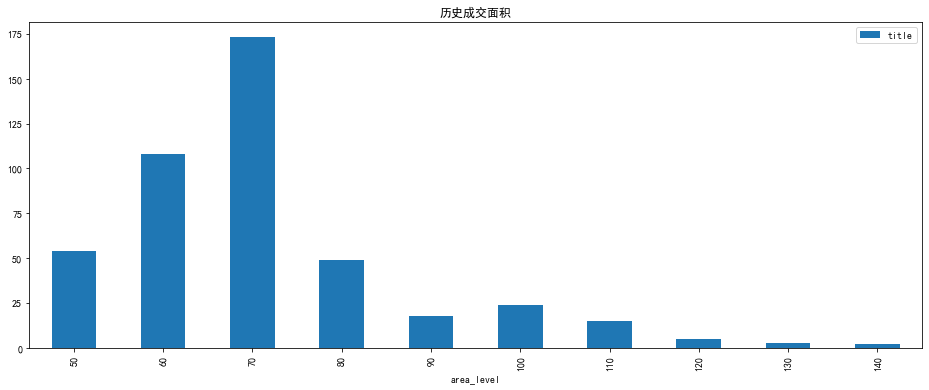

In [19]:
data.groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交面积')

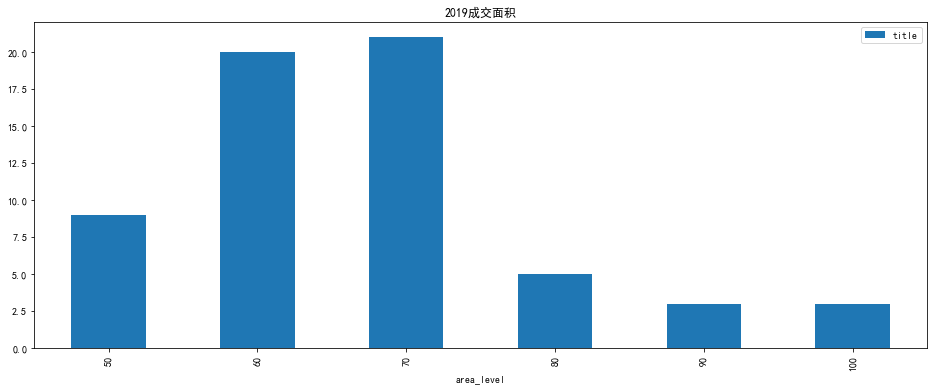

In [20]:
data[data['deal_date']>='2019'].groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交面积')

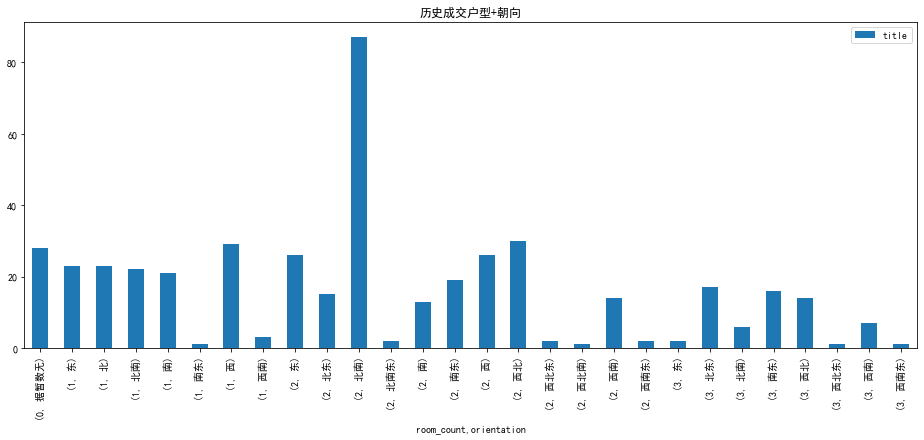

In [21]:
data.groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型+朝向')

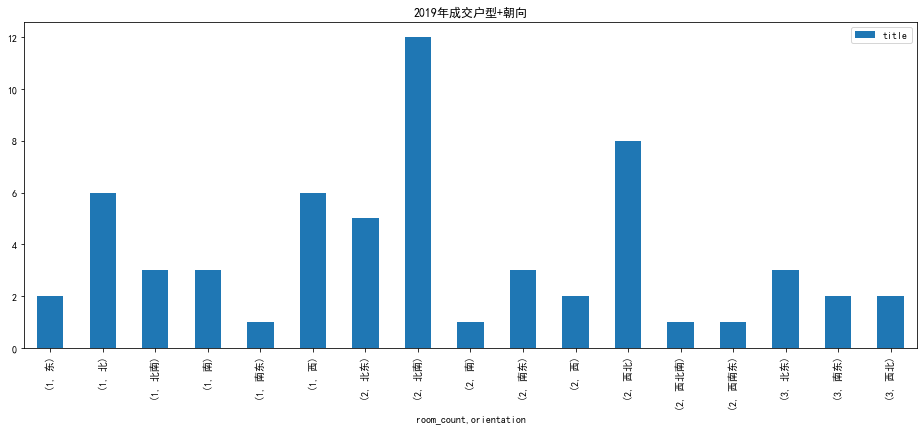

In [22]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交户型+朝向')

分户型朝向和楼层的成交分布

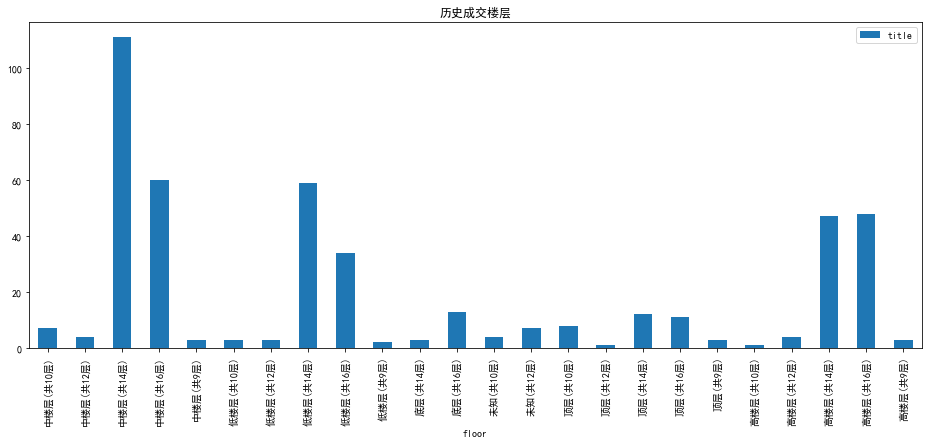

In [23]:
data.groupby(['floor']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交楼层')

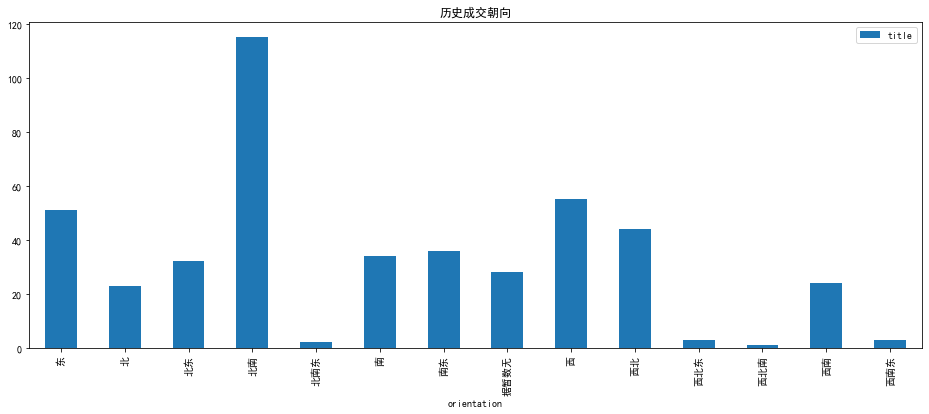

In [24]:
data.groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交朝向')

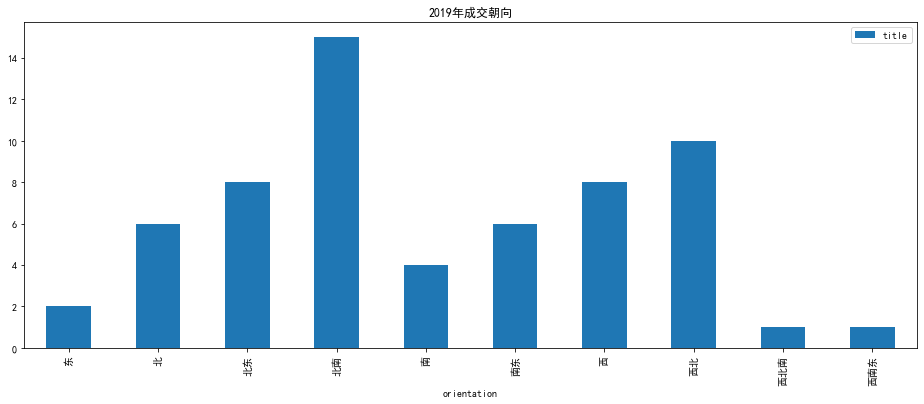

In [25]:
data[data['deal_date']>='2019'].groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交朝向')

In [26]:
data.groupby(['house_type','orientation','floor']).count()[['title']]

title
house_type orientation floor           
- -室- -厅   据暂数无        中楼层(共10层)      1
                       中楼层(共14层)      9
                       中楼层(共16层)      3
                       中楼层(共9层)       1
                       低楼层(共10层)      1
                       低楼层(共14层)      3
                       低楼层(共16层)      1
                       底层(共16层)       1
                       顶层(共10层)       1
                       顶层(共16层)       3
                       高楼层(共14层)      3
                       高楼层(共16层)      1
1室1厅1厨1卫   东           中楼层(共14层)     12
                       低楼层(共12层)      1
                       低楼层(共14层)      1
                       未知(共12层)       1
                       顶层(共14层)       1
                       高楼层(共10层)      1
                       高楼层(共12层)      4
                       高楼层(共14层)      2
           北           中楼层(共14层)      9
                       低楼层(共14层)     11
                       高楼层(共14层)      3
           北南          中楼层(共14层)      3
                       低楼层(共14层)      2
                       顶层(共10层)       5
                       顶层(共14层)       1
                       高楼层(共16层)      1
           南           中楼层(共12层)      1
                       中楼层(共14层)      2
                       中楼层(共16层)      4
                       低楼层(共14层)      1
                       低楼层(共16层)      4
                       底层(共16层)       1
                       高楼层(共14层)      1
                       高楼层(共16层)      6
           南东          中楼层(共14层)      1
           西           中楼层(共12层)      2
                       中楼层(共14层)     12
                       低楼层(共12层)      1
                       低楼层(共14层)      5
                       顶层(共14层)       1
                       高楼层(共14层)      8
           西南          中楼层(共16层)      1
                       低楼层(共14层)      1
                       顶层(共14层)       1
1室2厅1厨1卫   北南          中楼层(共14层)      4
                       低楼层(共14层)      1
                       顶层(共10层)       2
                       顶层(共14层)       1
                       高楼层(共14层)      2
           南           底层(共14层)       1
2室1厅1厨0卫   东           高楼层(共14层)      1
2室1厅1厨1卫   东           中楼层(共14层)      9
                       低楼层(共14层)      2
                       低楼层(共16层)      3
                       未知(共12层)       4
                       高楼层(共14层)      5
                       高楼层(共16层)      1
           北东          中楼层(共16层)      5
                       低楼层(共16层)      5
                       底层(共16层)       1
                       顶层(共16层)       1
                       高楼层(共16层)      3
           北南          中楼层(共10层)      6
                       中楼层(共14层)     25
                       中楼层(共16层)      6
                       低楼层(共10层)      2
                       低楼层(共14层)     15
                       底层(共14层)       2
                       未知(共10层)       4
                       顶层(共14层)       3
                       顶层(共16层)       2
                       高楼层(共14层)     12
                       高楼层(共16层)      5
           北南东         中楼层(共16层)      1
                       低楼层(共14层)      1
           南           中楼层(共14层)      4
                       中楼层(共16层)      1
                       低楼层(共14层)      5
                       底层(共16层)       1
                       高楼层(共16层)      2
           南东          中楼层(共16层)      6
                       低楼层(共16层)      2
                       底层(共16层)       1
                       顶层(共12层)       1
                       顶层(共16层)       1
                       高楼层(共14层)      1
                       高楼层(共16层)      7
           西           中楼层(共14层)      8
                       中楼层(共16层)      2
                       低楼层(共14层)      6
                       低楼层(共16层)      1
                       未知(共12层)       2
                       顶层(共14层)       1
                       高楼层(共14层)      4
           西北          中楼层(共16层)      8
                       低楼层(共16层)     12
                       底层(共16层)   

In [27]:
data.groupby(['area','orientation','floor']).count()[['title']]

title
area   orientation floor           
49.99  北           中楼层(共14层)      2
                   低楼层(共14层)      2
50.46  北           高楼层(共14层)      1
50.65  北           中楼层(共14层)      2
                   低楼层(共14层)      2
                   高楼层(共14层)      1
52.24  南           中楼层(共16层)      1
                   低楼层(共16层)      3
                   底层(共16层)       1
                   高楼层(共16层)      3
       据暂数无        高楼层(共16层)      1
52.30  南           中楼层(共16层)      3
                   低楼层(共16层)      1
                   高楼层(共16层)      3
53.48  西           高楼层(共14层)      1
53.68  西           中楼层(共14层)      1
                   高楼层(共14层)      1
53.79  据暂数无        中楼层(共14层)      1
       西           中楼层(共14层)      1
                   低楼层(共14层)      1
                   顶层(共14层)       1
                   高楼层(共14层)      1
53.84  西           中楼层(共14层)      2
54.00  西           低楼层(共14层)      1
54.13  据暂数无        中楼层(共14层)      1
       西           中楼层(共14层)      1
                   低楼层(共14层)      1
                   高楼层(共14层)      1
54.25  北           中楼层(共14层)      1
                   低楼层(共14层)      2
                   高楼层(共14层)      1
       据暂数无        高楼层(共14层)      1
54.39  北南          顶层(共10层)       1
54.40  东           未知(共12层)       1
                   高楼层(共12层)      1
54.41  北南          顶层(共10层)       4
       据暂数无        顶层(共10层)       1
55.34  东           低楼层(共14层)      1
                   顶层(共14层)       1
                   高楼层(共14层)      1
       北           中楼层(共14层)      1
                   低楼层(共14层)      2
       西           中楼层(共14层)      5
                   低楼层(共14层)      1
                   高楼层(共14层)      1
55.42  东           中楼层(共14层)      4
       据暂数无        低楼层(共14层)      1
55.43  东           中楼层(共14层)      1
55.48  东           中楼层(共14层)      3
                   高楼层(共14层)      1
       西           低楼层(共14层)      1
                   高楼层(共14层)      1
55.65  西           中楼层(共14层)      1
55.70  西           低楼层(共14层)      1
                   高楼层(共14层)      1
55.78  东           低楼层(共12层)      1
                   未知(共12层)       1
                   高楼层(共12层)      3
55.82  南           中楼层(共12层)      1
55.83  西           中楼层(共12层)      2
                   低楼层(共12层)      1
57.32  北南          中楼层(共14层)      3
       南           中楼层(共14层)      1
58.85  北           中楼层(共14层)      2
                   低楼层(共14层)      1
59.06  东           中楼层(共14层)      4
       据暂数无        中楼层(共14层)      1
       西           中楼层(共14层)      2
                   高楼层(共14层)      1
       西南          低楼层(共14层)      1
                   顶层(共14层)       1
59.47  北南          中楼层(共14层)      3
                   顶层(共14层)       2
                   高楼层(共14层)      2
59.54  北南          中楼层(共14层)      1
                   低楼层(共14层)      2
       南           底层(共14层)       1
59.56  北南          中楼层(共14层)      1
59.64  北南          低楼层(共14层)      1
59.66  北南          顶层(共10层)       2
61.12  西北南         顶层(共9层)        1
61.31  北           中楼层(共14层)      1
                   低楼层(共14层)      2
63.19  南           中楼层(共14层)      1
                   低楼层(共14层)      1
                   高楼层(共14层)      1
       南东          中楼层(共14层)      1
64.61  东           未知(共12层)       3
       据暂数无        低楼层(共14层)      1
       西           中楼层(共14层)      1
                   低楼层(共14层)      1
64.68  东           中楼层(共14层)      4
                   低楼层(共14层)      1
64.80  西北          底层(共16层)       1
64.91  北东          中楼层(共16层)      2
                   低楼层(共16层)      4
       西北          中楼层(共16层)      3
                   低楼层(共16层)      3
64.97  北东          中楼层(共16层)      1
                   低楼层(共16层)      1
       西北          中楼层(共16层)      1
                   低楼层(共16层)      2
                   高楼层(共16层)      2
65.32  北南          未知(共10层)       1
65.40  北南          中楼层(共14层)      4
                   顶层(共14层)       2
                   高楼层(共14层)      1
       据暂数无        中楼层(共14层)      1
65.45  北南          中楼层(共10层)      1
65.49  北南          中楼层(共14层)      

In [28]:
data.groupby(['area']).count()[['title']]

,title
area,
49.99,4
50.46,1
50.65,5
52.24,9
52.30,7
53.48,1
53.68,2
53.79,5
53.84,2


### 2）换手率

分户型分析换手情况

成交超过1次，分户型交易占比

In [29]:
data.groupby(['room_count', 'history_trade_count']).count()[['title']]

title
room_count history_trade_count       
0          1                       25
           2                        2
           3                        1
1          1                      109
           2                       13
2          1                      218
           2                       17
           3                        2
3          1                       58
           2                        6

In [30]:
(data[data['history_trade_count']>1].groupby('room_count').count()/2/data.groupby('room_count').count())[['title']]

,title
room_count,
0,0.053571
1,0.053279
2,0.040084
3,0.046875


### 3）带看与成交周期

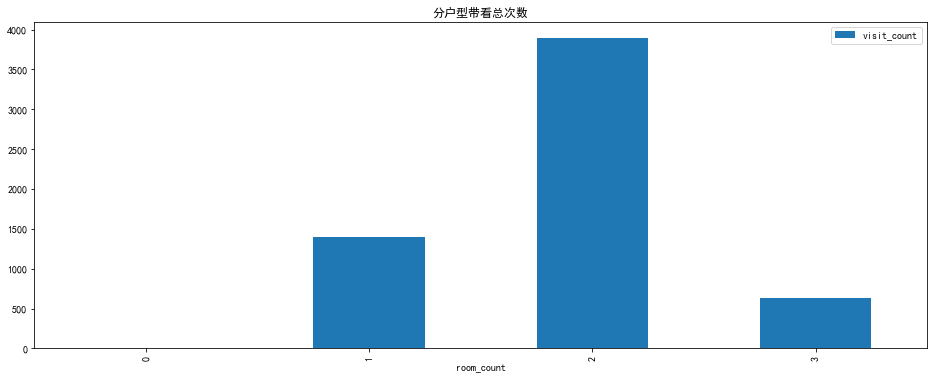

In [31]:
data.groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型带看总次数')

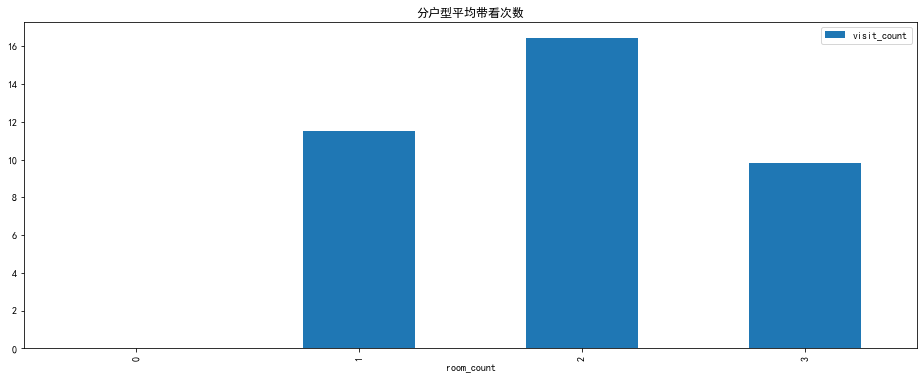

In [32]:
data.groupby(['room_count']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型平均带看次数')

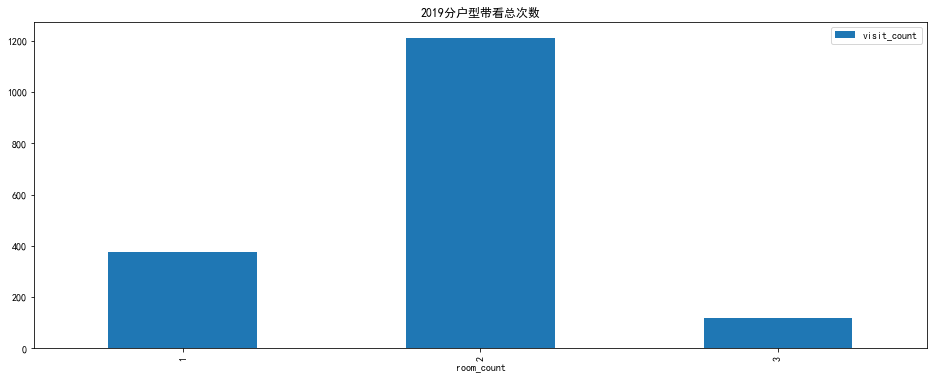

In [33]:
data[data['deal_date']>='2019'].groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019分户型带看总次数')

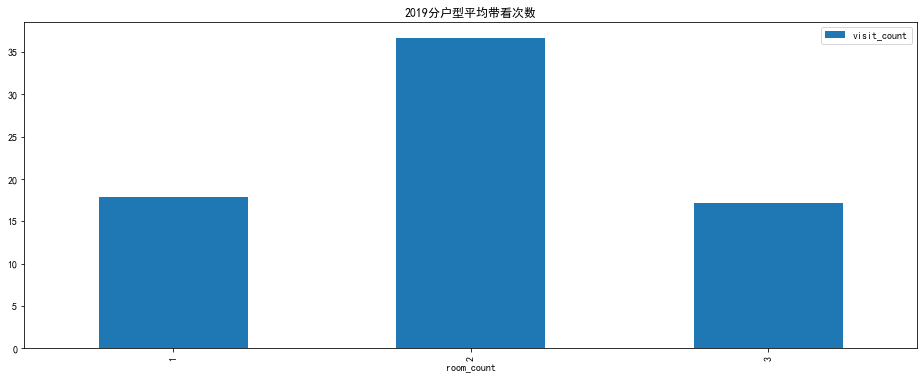

In [34]:
data[data['deal_date']>='2019'].groupby(['room_count']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019分户型平均带看次数')

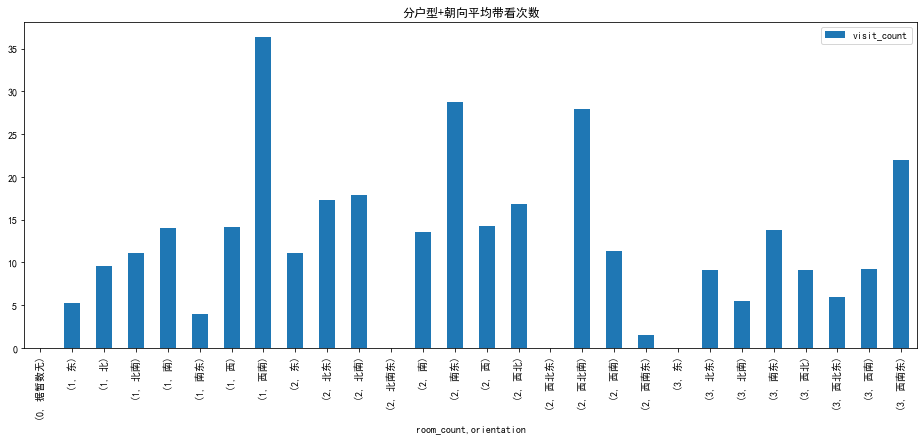

In [35]:
data.groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型+朝向平均带看次数')

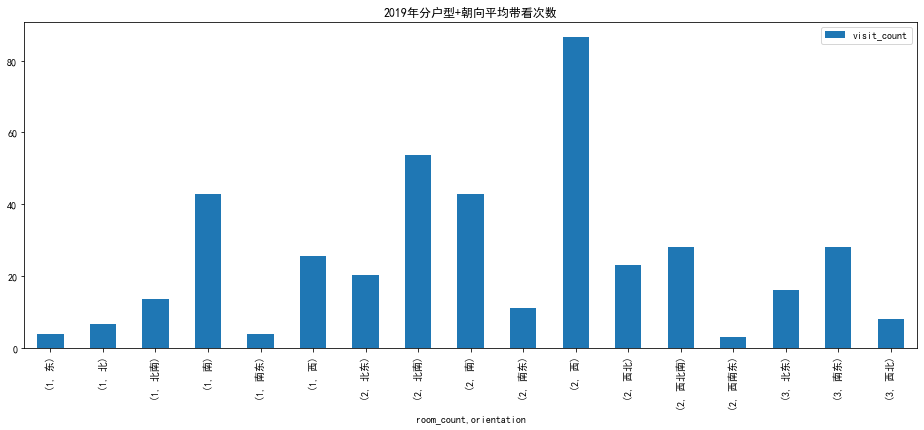

In [36]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019年分户型+朝向平均带看次数')

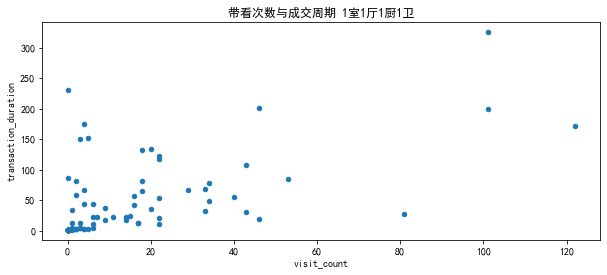

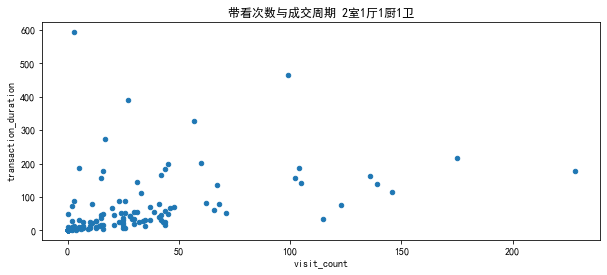

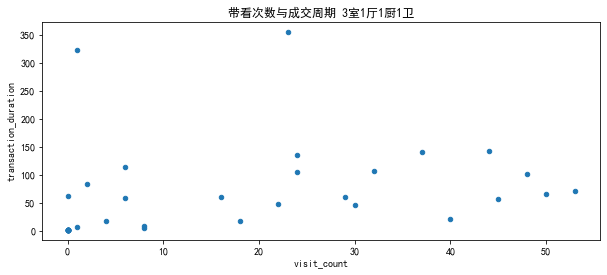

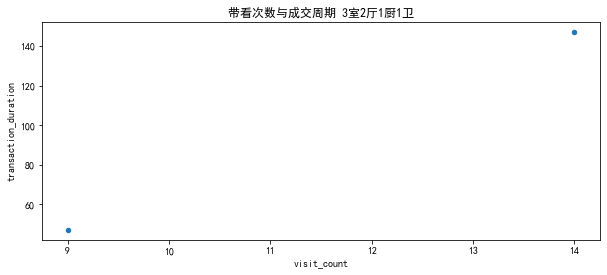

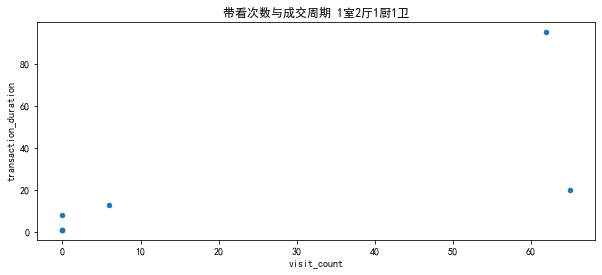

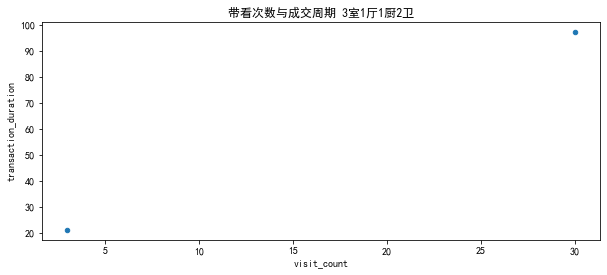

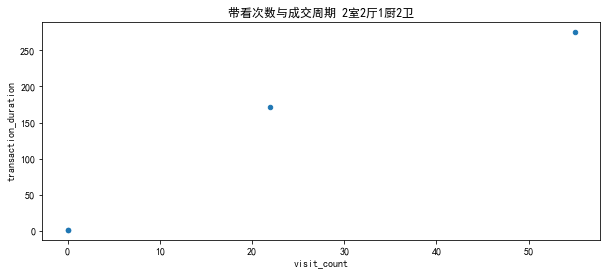

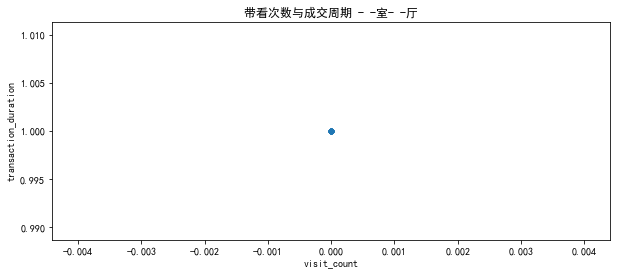

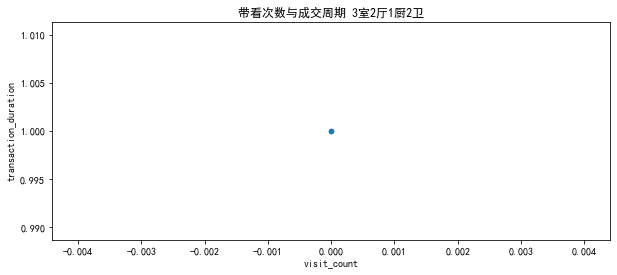

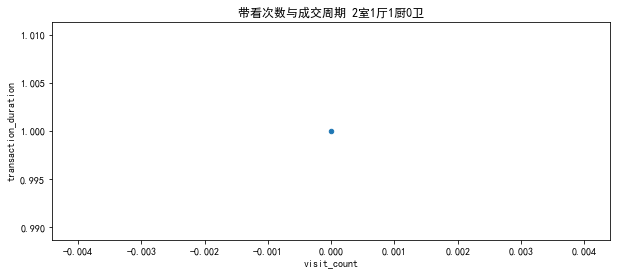

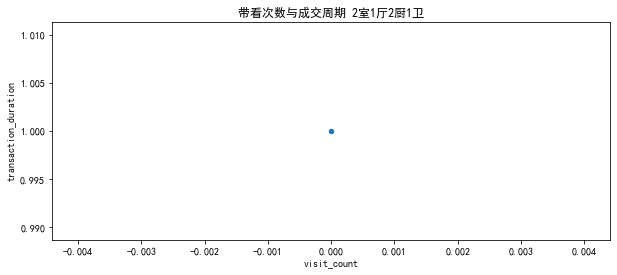

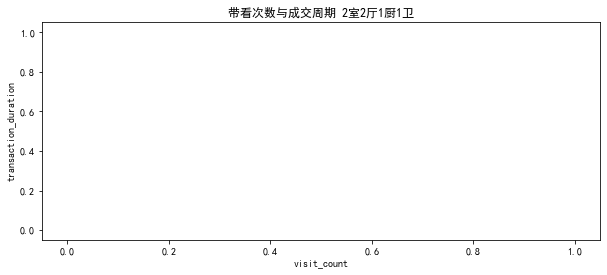

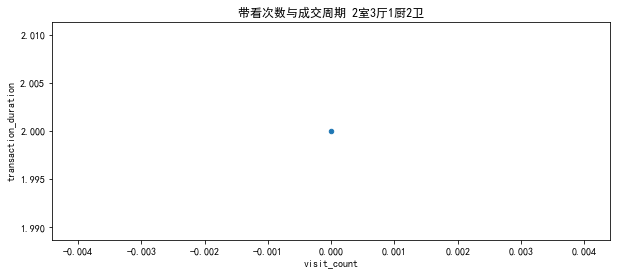

In [37]:
for t in data['house_type'].unique():
    data[data['house_type']==t][['transaction_duration','visit_count']].plot(kind='scatter',x='visit_count', y='transaction_duration',figsize=(10,4),title='带看次数与成交周期 '+t)

分户型成交周期分布

In [38]:
data.groupby(['room_count','orientation','floor']).describe()[['transaction_duration']]

transaction_duration                          \
                                                count        mean         std   
room_count orientation floor                                                    
0          据暂数无        中楼层(共10层)                  1.0    1.000000         NaN   
                       中楼层(共14层)                  9.0    1.000000    0.000000   
                       中楼层(共16层)                  3.0    1.000000    0.000000   
                       中楼层(共9层)                   1.0    1.000000         NaN   
                       低楼层(共10层)                  0.0         NaN         NaN   
                       低楼层(共14层)                  3.0    1.000000    0.000000   
                       低楼层(共16层)                  1.0    1.000000         NaN   
                       底层(共16层)                   1.0    1.000000         NaN   
                       顶层(共10层)                   1.0    1.000000         NaN   
                       顶层(共16层)                   3.0    1.000000    0.000000   
                       高楼层(共14层)                  3.0    1.000000    0.000000   
                       高楼层(共16层)                  1.0    1.000000         NaN   
1          东           中楼层(共14层)                 10.0   51.200000   67.980062   
                       低楼层(共12层)                  1.0   81.000000         NaN   
                       低楼层(共14层)                  0.0         NaN         NaN   
                       未知(共12层)                   1.0    1.000000         NaN   
                       顶层(共14层)                   1.0    1.000000         NaN   
                       高楼层(共10层)                  1.0    1.000000         NaN   
                       高楼层(共12层)                  2.0   51.000000   11.313708   
                       高楼层(共14层)                  1.0    4.000000         NaN   
           北           中楼层(共14层)                  6.0   57.833333   75.634428   
                       低楼层(共14层)                  9.0   32.000000   50.544535   
                       高楼层(共14层)                  3.0    3.000000    2.000000   
           北南          中楼层(共14层)                  3.0   23.333333   28.919428   
                       低楼层(共14层)                  1.0    1.000000         NaN   
                       顶层(共10层)                   6.0   68.500000   56.613603   
                       顶层(共14层)                   2.0    1.000000    0.000000   
                       高楼层(共14层)                  2.0   51.500000   61.518290   
                       高楼层(共16层)                  1.0  231.000000         NaN   
           南           中楼层(共12层)                  1.0    1.000000         NaN   
                       中楼层(共14层)                  1.0   12.000000         NaN   
                       中楼层(共16层)                  3.0   25.333333   27.061658   
                       低楼层(共14层)                  0.0         NaN         NaN   
                       低楼层(共16层)                  4.0   51.750000   81.573586   
                       底层(共14层)                   0.0         NaN         NaN   
                       底层(共16层)                   1.0   13.000000         NaN   
                       高楼层(共14层)                  1.0   22.000000         NaN   
                       高楼层(共16层)                  5.0   16.400000   17.686153   
           南东          中楼层(共14层)                  1.0  175.000000         NaN   
           西           中楼层(共12层)                  2.0  183.500000  200.111219   
                       中楼层(共14层)                  9.0   47.555556   53.898310   
                       低楼层(共12层)                  1.0   69.000000         NaN   
                       低楼层(共14层)                  3.0   12.000000    9.539392   
                       顶层(共14层)                   1.0   36.000000         NaN   
                       高楼层(共14层)                  6.0   29.500000   49.439862   
           西南          中楼层(共16层)                  1.0   53.000000         NaN   
                       低楼层(共14层)                  1.0   11.00000

tuple index out of range 3室2厅1厨1卫
tuple index out of range 1室2厅1厨1卫
tuple index out of range 3室1厅1厨2卫
tuple index out of range 2室2厅1厨2卫
tuple index out of range - -室- -厅
tuple index out of range 3室2厅1厨2卫
tuple index out of range 2室1厅1厨0卫
tuple index out of range 2室1厅2厨1卫
tuple index out of range 2室2厅1厨1卫
tuple index out of range 2室3厅1厨2卫


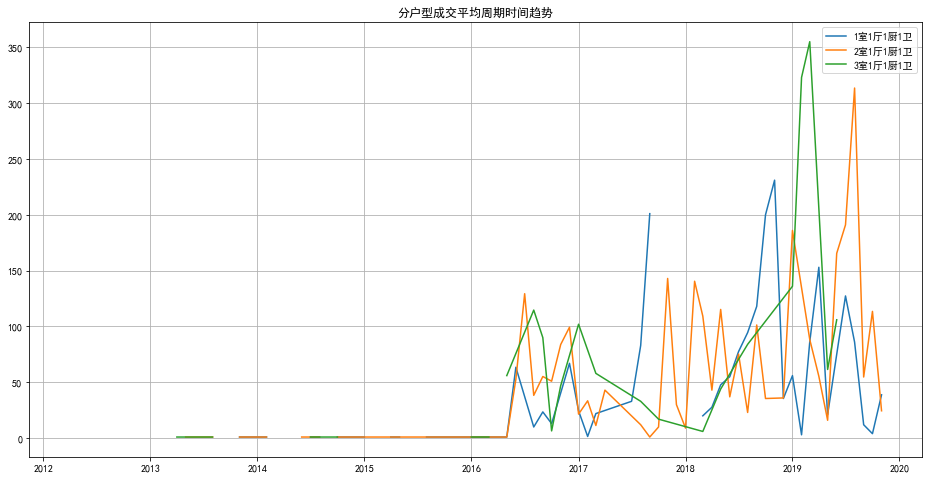

In [94]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    try:
        plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_duration'])
    except Exception as e:
        print(e,t)
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型成交平均周期时间趋势')
plt.show()

### 4) 成交量时间趋势

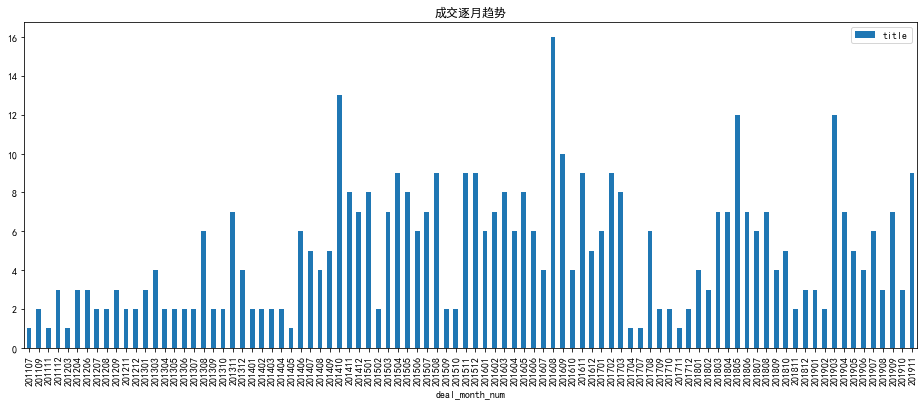

In [62]:
data.groupby('deal_month_num').count()[['title']].plot(kind='bar', figsize=(16,6), title='成交逐月趋势')
#ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))

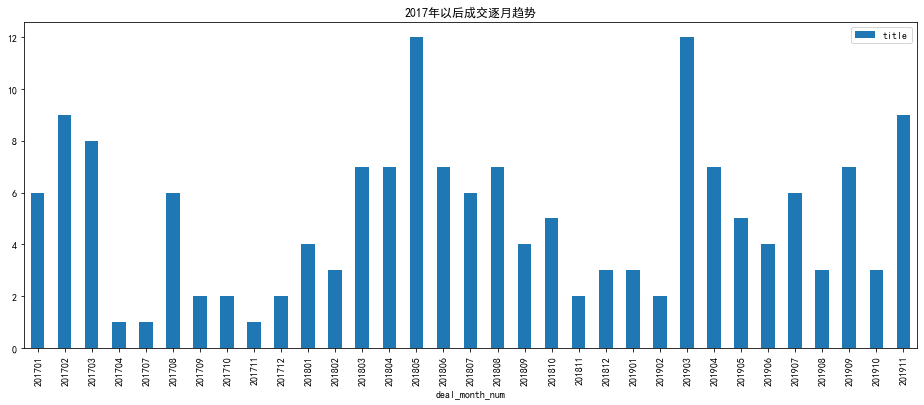

In [63]:
data[data['deal_date']>='2017'].groupby('deal_month_num').count()[['title']].plot(kind='bar', figsize=(16,6), title='2017年以后成交逐月趋势')

## 2.2 价格机制

相同面积，房间数下，影响价格的因素主要是朝向和楼层

### 1）分户型平均成交价格走势

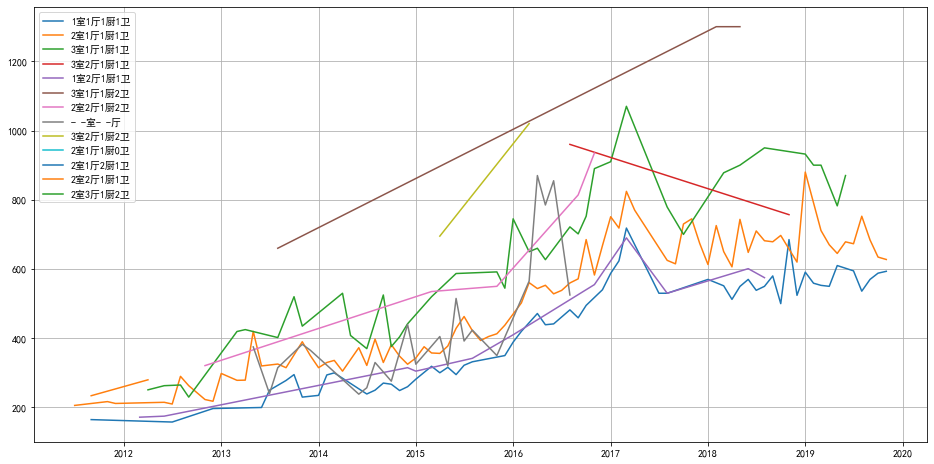

In [39]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.show()

### 2）2019年分户型不同楼层成交均价

In [40]:
data[data['deal_date']>'2019'].groupby(['house_type','area','floor', 'build_year'])[['transaction_price','per_area_price']].mean()

transaction_price  per_area_price
house_type area  floor     build_year                                   
1室1厅1厨1卫   49.99 中楼层(共14层) 2004                    536.0       10.722144
           50.46 高楼层(共14层) 2004                    507.0       10.047562
           50.65 低楼层(共14层) 2004                    509.0       10.049358
           52.30 低楼层(共16层) 2003                    565.0       10.803059
                 高楼层(共16层) 2003                    605.0       11.567878
           54.13 中楼层(共14层) 2004                    535.0        9.883614
           54.25 高楼层(共14层) 2003                    559.0       10.304147
           54.41 顶层(共10层)  2004                    608.5       11.183606
           55.34 中楼层(共14层) 2004                    584.0       10.552945
                 高楼层(共14层) 2004                    588.0       10.625226
           55.48 低楼层(共14层) 2004                    560.0       10.093727
           55.65 中楼层(共14层) 2004                    596.0       10.709793
           55.70 高楼层(共14层) 2004                    596.0       10.700180
           55.78 低楼层(共12层) 2004                    538.0        9.645034
           55.83 中楼层(共12层) 2004                    580.0       10.388680
           57.32 中楼层(共14层) 2004                    570.0        9.944173
           58.85 中楼层(共14层) 2004                    599.0       10.178420
           59.47 中楼层(共14层) 2004                    591.0        9.937784
           63.19 中楼层(共14层) 2004                    650.0       10.286438
2室1厅1厨1卫   61.12 顶层(共9层)   2004                    682.0       11.158377
           64.80 底层(共16层)  2003                    605.0        9.336420
           64.91 中楼层(共16层) 2003                    635.0        9.782776
           64.97 中楼层(共16层) 2003                    605.0        9.311990
                 低楼层(共16层) 2003                    624.0        9.604433
           65.40 中楼层(共14层) 2004                    655.0       10.015291
           65.69 中楼层(共14层) 2004                    600.0        9.133810
           65.93 中楼层(共14层) 2004                    635.0        9.631427
                 低楼层(共14层) 2004                    645.5        9.790687
           66.05 中楼层(共14层) 2004                    730.0       11.052233
           66.21 低楼层(共10层) 2004                    674.0       10.179731
           66.65 中楼层(共10层) 2004                    680.0       10.202551
           66.96 中楼层(共16层) 2003                    665.0        9.931302
           67.03 低楼层(共16层) 2002                    630.0        9.398777
                           2003                    595.0        8.876622
                 高楼层(共16层) 2003                    635.0        9.473370
           67.09 中楼层(共16层) 2003                    657.0        9.792816
           69.60 中楼层(共16层) 2003                    712.0       10.229885
                 高楼层(共16层) 2003                    699.0       10.043103
           70.18 高楼层(共14层) 2004                    750.0       10.686805
           71.81 低楼层(共14层) 2003                    725.0       10.096087
           72.46 中楼层(共14层) 2003                    685.0        9.453492
           73.68 中楼层(共14层) 2003                    745.0       10.111292
           73.72 高楼层(共14层) 2003                    725.0        9.834509
           75.39 中楼层(共16层) 2002                    835.0       11.075739
                           2003                    807.0       10.704337
           83.32 中楼层(共16层) 2003                    850.0       10.201632
           98.36 低楼层(共16层) 2004                    880.0        8.946726
3室1厅1厨1卫   82.77 中楼层(共16层) 2002                    800.0        9.665338
                 底层(共16层)  2003                    765.0        9.242479
           90.10 中楼层(共14层) 2004                    930.0       10.321865
                 高楼层(共14层) 2004                    932.0       10.344062
           90.25 低楼层(共14层) 2003                    810.0        8.975069
           95.85 中楼层(共14层) 2004                    900.0        9.389671

### 3）各个户型最后成交价格

户型锚定价格

In [41]:
data.sort_values('deal_date').groupby(['house_type','area','floor'])[['transaction_price','deal_date']].last()

transaction_price  deal_date
house_type area   floor                                  
- -室- -厅   52.24  高楼层(共16层)                320 2015-05-01
           53.79  中楼层(共14层)                245 2014-06-01
           54.13  中楼层(共14层)                232 2014-06-01
           54.25  高楼层(共14层)                257 2014-07-01
           54.41  顶层(共10层)                 240 2013-07-01
           55.42  低楼层(共14层)                350 2015-11-01
           59.06  中楼层(共14层)                276 2014-10-01
           64.61  低楼层(共14层)                310 2013-12-01
           65.40  中楼层(共14层)                285 2013-08-01
           65.49  中楼层(共10层)                392 2015-07-01
                  中楼层(共14层)                325 2015-01-01
           65.79  高楼层(共14层)                330 2014-08-01
           66.21  低楼层(共10层)                525 2016-08-01
           66.89  顶层(共16层)                 425 2015-08-01
           67.09  顶层(共16层)                 325 2015-01-01
           72.35  低楼层(共14层)                565 2016-03-01
           72.46  中楼层(共14层)                422 2015-08-01
           73.72  中楼层(共14层)                355 2013-11-01
           79.73  中楼层(共16层)                405 2015-04-01
           80.64  中楼层(共9层)                 421 2013-12-01
           82.77  中楼层(共16层)                410 2013-11-01
           84.23  中楼层(共16层)                870 2016-04-01
           91.39  中楼层(共14层)                375 2013-05-01
           99.50  高楼层(共14层)                440 2014-12-01
           110.37 低楼层(共16层)                515 2015-06-01
                  顶层(共16层)                 785 2016-05-01
           121.49 底层(共16层)                 855 2016-06-01
1室1厅1厨1卫   49.99  中楼层(共14层)                536 2019-08-01
                  低楼层(共14层)                249 2014-11-01
           50.46  高楼层(共14层)                507 2019-03-02
           50.65  中楼层(共14层)                500 2018-10-23
                  低楼层(共14层)                509 2019-03-20
                  高楼层(共14层)                260 2014-12-20
           52.24  中楼层(共16层)                543 2018-04-27
                  低楼层(共16层)                530 2017-07-27
                  底层(共16层)                 495 2016-10-01
                  高楼层(共16层)                560 2018-05-30
           52.30  中楼层(共16层)                535 2018-05-14
                  低楼层(共16层)                565 2019-04-10
                  高楼层(共16层)                605 2019-07-14
           53.48  高楼层(共14层)                250 2013-07-01
           53.68  高楼层(共14层)                239 2014-07-25
           53.79  中楼层(共14层)                235 2014-01-01
                  顶层(共14层)                 446 2016-09-26
                  高楼层(共14层)                530 2017-08-28
           53.84  中楼层(共14层)                550 2018-08-05
           54.00  低楼层(共14层)                440 2016-04-01
           54.13  中楼层(共14层)                535 2019-04-01
                  低楼层(共14层)                200 2013-06-07
                  高楼层(共14层)                500 2018-12-29
           54.25  中楼层(共14层)                448 2016-08-15
                  低楼层(共14层)                463 2018-04-01
                  高楼层(共14层)                559 2019-02-28
           54.40  高楼层(共12层)                530 2017-08-06
           54.41  顶层(共10层)                 607 2019-11-24
           55.34  中楼层(共14层)                580 2019-11-20
                  低楼层(共14层)                310 2015-05-16
                  顶层(共14层)                 270 2015-01-01
                  高楼层(共14层)                588 2019-10-25
           55.42  中楼层(共14层)                497 2018-07-07
           55.43  中楼层(共14层)                720 2017-03-13
           55.48  中楼层(共14层)                554 2018-05-20
                  低楼层(共14层)                560 2019-03-14
                  高楼层(共14层)                550 2018-05-08
           55.65  中楼层(共14层)                596 2019-11-27
           55.70  低楼层(共14层)                570 2018-06-28
                  高楼层(共14层)                596 2019-11-30
           55.78  低楼层(共12层)

### 4）分户型楼层以及时间，挂牌价与成交价gap分布

In [42]:
#data.groupby(['house_type','area','floor','deal_year'])[['transaction_listed_price_gap']].describe()
data.groupby(['house_type','deal_year'])[['transaction_listed_price_gap']].describe()

transaction_listed_price_gap                         \
                                             count        mean        std   
house_type deal_year                                                        
- -室- -厅   2013-01-01                          0.0         NaN        NaN   
           2014-01-01                          0.0         NaN        NaN   
           2015-01-01                          0.0         NaN        NaN   
           2016-01-01                          0.0         NaN        NaN   
1室1厅1厨1卫   2011-01-01                          1.0    0.000000        NaN   
           2012-01-01                          2.0  -10.000000   2.828427   
           2013-01-01                          5.0   -6.400000   6.107373   
           2014-01-01                         14.0   -5.571429   8.168554   
           2015-01-01                         15.0   -5.666667   6.320790   
           2016-01-01                         19.0    1.842105  15.500047   
           2017-01-01                         11.0  -12.000000  18.160396   
           2018-01-01                         23.0  -17.217391   9.581974   
           2019-01-01                         21.0  -17.285714  11.752203   
1室2厅1厨1卫   2012-01-01                          2.0   -9.000000   1.414214   
           2014-01-01                          1.0   -5.000000        NaN   
           2015-01-01                          2.0   -6.500000   2.121320   
           2016-01-01                          2.0   -7.500000   3.535534   
           2017-01-01                          2.0  -11.500000   2.121320   
           2018-01-01                          2.0  -17.000000  11.313708   
2室1厅1厨0卫   2015-01-01                          1.0    5.000000        NaN   
2室1厅1厨1卫   2011-01-01                          5.0  -12.000000  16.186414   
           2012-01-01                          6.0   -4.333333   3.723797   
           2013-01-01                         16.0   -6.187500  14.882736   
           2014-01-01                         26.0   -9.730769  10.872195   
           2015-01-01                         39.0   -3.230769  16.606057   
           2016-01-01                         45.0    0.866667  25.287079   
           2017-01-01                         19.0   -8.842105  12.996851   
           2018-01-01                         35.0  -24.085714  23.406097   
           2019-01-01                         31.0  -20.548387  12.587927   
2室1厅2厨1卫   2015-01-01                          1.0  -10.000000        NaN   
2室2厅1厨1卫   2011-01-01                          1.0   -1.000000        NaN   
           2012-01-01                          1.0  -20.000000        NaN   
2室2厅1厨2卫   2012-01-01                          1.0   -9.000000        NaN   
           2015-01-01                          2.0  -37.500000  38.890873   
           2016-01-01                          2.0   -3.000000   4.242641   
2室3厅1厨2卫   2012-01-01                          1.0    0.000000        NaN   
3室1厅1厨1卫   2012-01-01                          5.0   -2.000000  10.222524   
           2013-01-01                          6.0   -3.166667   4.355074   
           2014-01-01                         10.0   -9.300000  17.657545   
           2015-01-01                          8.0   -4.000000  14.520921   
           2016-01-01                         12.0  -10.666667  15.939279   
           2017-01-01                          5.0  -24.000000  43.954522   
           2018-01-01                          4.0  -64.750000  52.379226   
           2019-01-01                          7.0  -42.714286  30.302444   
3室1厅1厨2卫   2013-01-01                          1.0  -15.000000        NaN   
           2018-01-01                          2.0 -100.000000  70.710678   
3室2厅1厨1卫   2016-01-01                          1.0  -11.000000        NaN   
           2018-01-01                          1.0  -38.000000        NaN   
3室2厅1厨2卫   2015-01-01                          1.0    0.000000        NaN   
           2016-01

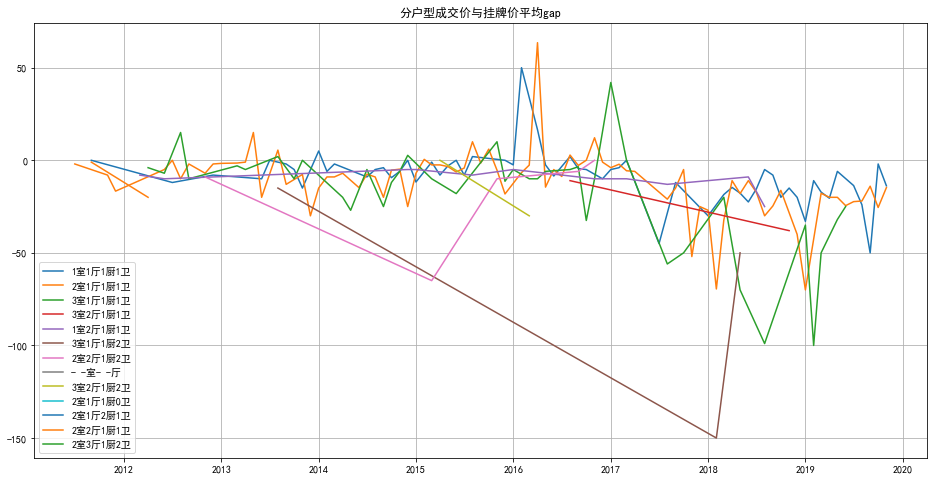

In [43]:
#plt.figure(figsize=(16, 8))
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_listed_price_gap'].astype(float))
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型成交价与挂牌价平均gap')
plt.show()

D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
D:\install\Continuum\miniconda3\envs\data_mine\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


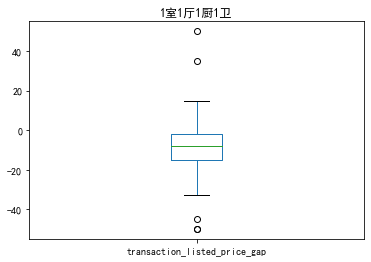

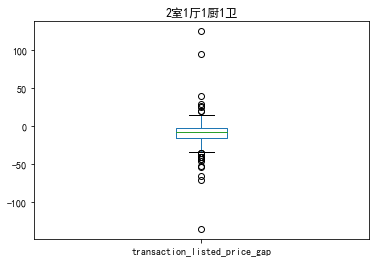

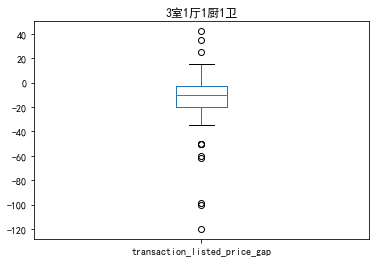

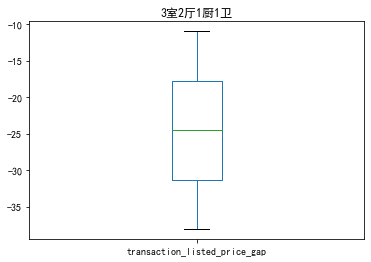

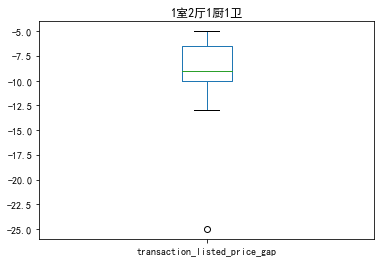

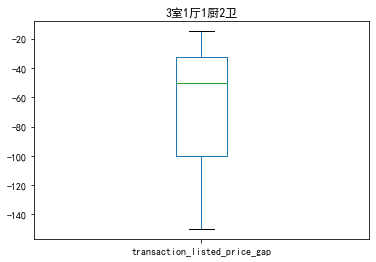

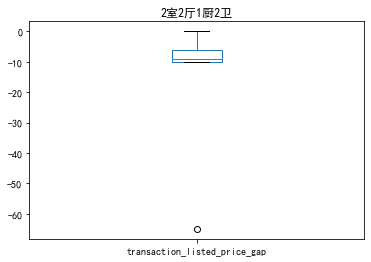

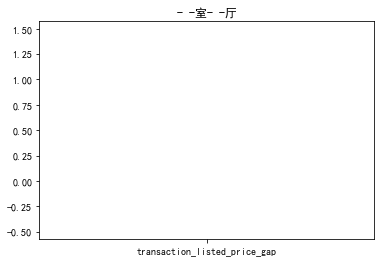

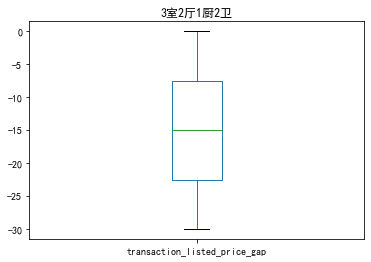

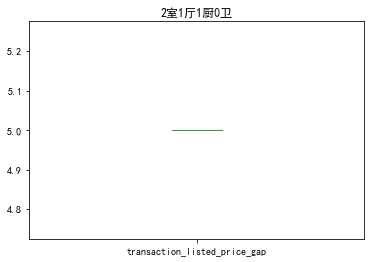

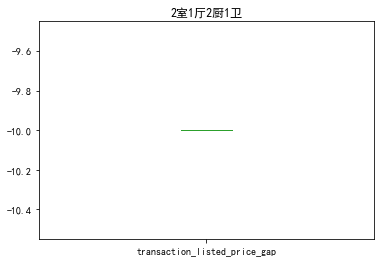

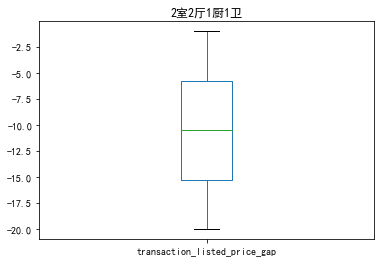

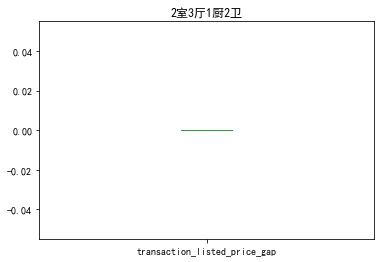

In [86]:

for t in data['house_type'].unique():
    data[data['house_type']==t][['transaction_listed_price_gap']].plot(kind='box', title=t)


In [44]:
#pd.plotting.scatter_matrix(data['transaction_duration','visit_count'], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
#import matplotlib.pyplot as plt
#transaction_duration=data['transaction_duration']
#plt.figure(figsize=(20, 5))
#for i, col in enumerate(['visit_count']):
#    plt.subplot(1, 3, i+1)
#    plt.plot(data[col], transaction_duration, 'o')
#    plt.title(col)
#    plt.xlabel(col)
#plt.ylabel('transaction_duration')

### 5) 候选目标户型价格分析

In [64]:
candidate = data[(abs((data['area']-55))<=1) & (data['deal_year']>='2017')]

In [65]:
candidate.groupby('floor').count()[['title']]

,title
floor,
中楼层(共12层),1
中楼层(共14层),9
低楼层(共12层),2
低楼层(共14层),3
顶层(共10层),5
高楼层(共12层),3
高楼层(共14层),5


In [66]:
candidate[['title','deal_month', 'floor', 'transaction_price']].sort_values('deal_month').head(100)

,title,deal_month,floor,transaction_price
141,畅柳园 1室1厅 55.43平米,2017-03-01,中楼层(共14层),720
147,畅柳园 1室2厅 54.39平米,2017-08-01,顶层(共10层),530
145,畅柳园 1室1厅 54.4平米,2017-08-01,高楼层(共12层),530
121,畅柳园 1室1厅 55.78平米,2018-01-01,高楼层(共12层),570
107,畅柳园 1室1厅 55.42平米,2018-03-01,中楼层(共14层),548
112,畅柳园 1室1厅 54.25平米,2018-04-01,低楼层(共14层),463
118,畅柳园 1室1厅 55.48平米,2018-05-01,高楼层(共14层),550
93,畅柳园 1室1厅 55.48平米,2018-05-01,中楼层(共14层),554
98,畅柳园 1室1厅 55.78平米,2018-06-01,高楼层(共12层),570
97,畅柳园 1室1厅 54.41平米,2018-06-01,顶层(共10层),580


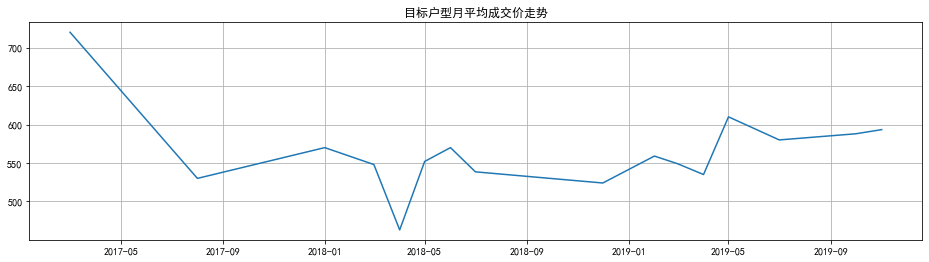

In [67]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
plt.plot(candidate.groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.title('目标户型月平均成交价走势')
plt.show()

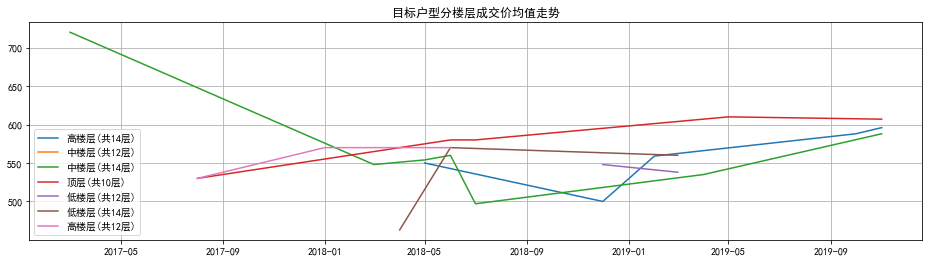

In [68]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['floor'].unique():
    plt.plot(candidate[candidate['floor']==t].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(candidate['floor'].unique(),loc='best')
plt.title('目标户型分楼层成交价均值走势')
plt.show()

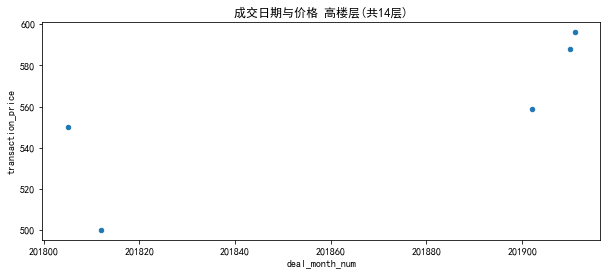

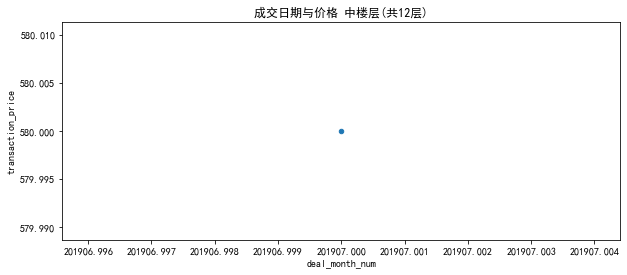

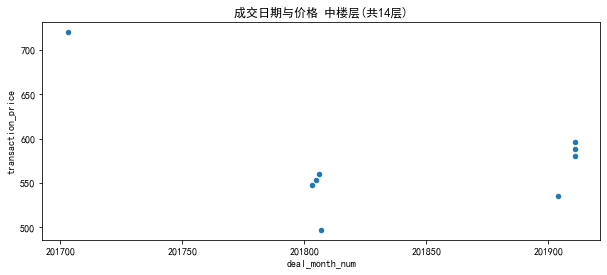

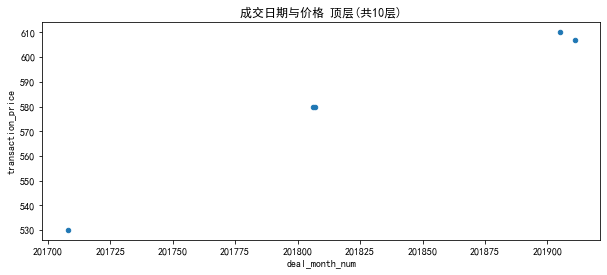

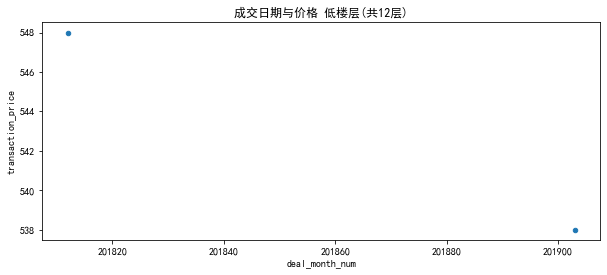

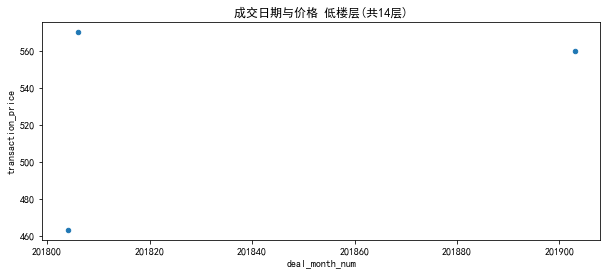

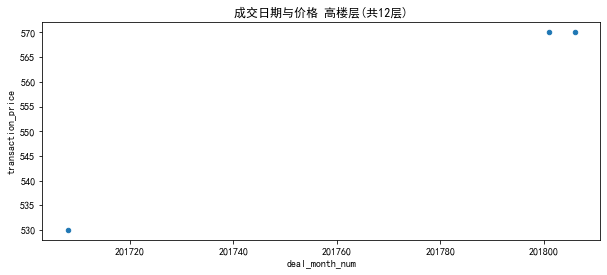

In [69]:
for t in candidate['floor'].unique():
    ax=candidate[candidate['floor']==t][['transaction_price','deal_month_num']].plot(kind='scatter',x='deal_month_num', y='transaction_price',figsize=(10,4),title='成交日期与价格 '+t)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)

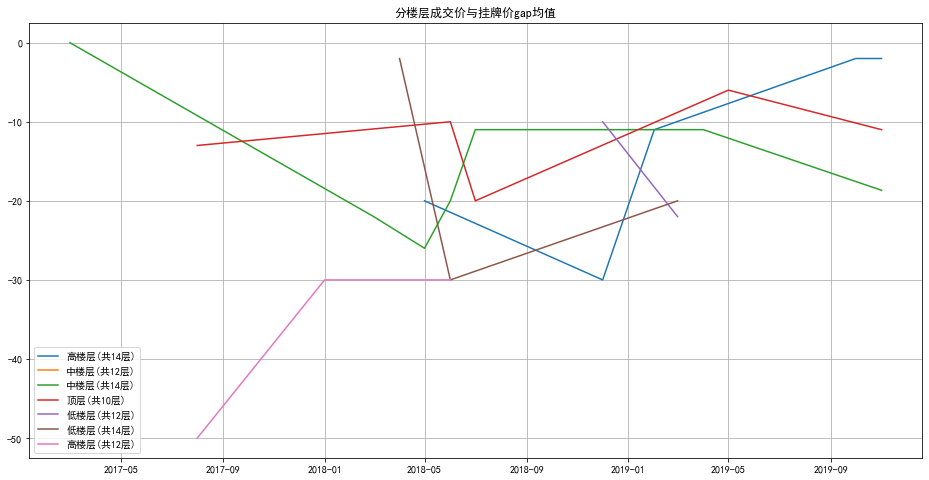

In [70]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['floor'].unique():
    plt.plot(candidate[candidate['floor']==t].groupby(['deal_month']).mean()['transaction_listed_price_gap'].astype(float))
plt.grid(True)
plt.legend(candidate['floor'].unique(),loc='best')
plt.title('分楼层成交价与挂牌价gap均值')
plt.show()

价格gap线框图分布

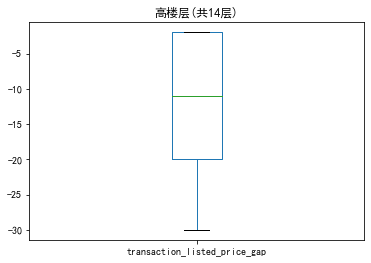

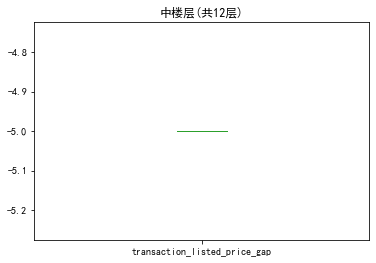

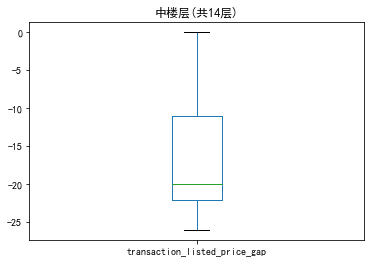

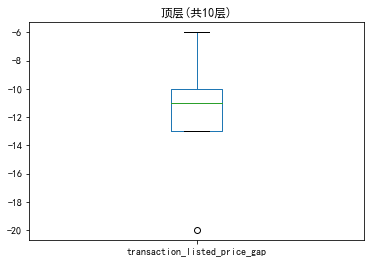

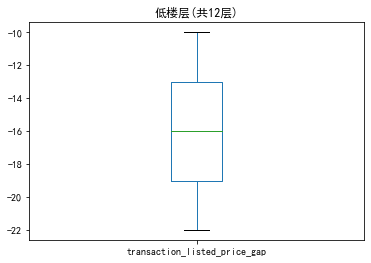

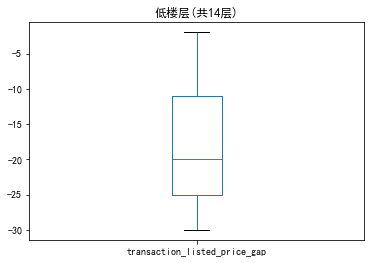

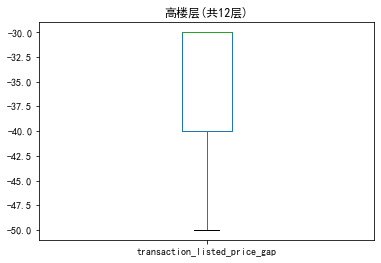

In [82]:
for t in candidate['floor'].unique():
    candidate[candidate['floor']==t][['transaction_listed_price_gap']].plot(kind='box', title=t)
